In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             roc_auc_score, confusion_matrix, roc_curve, 
                             precision_recall_curve, f1_score)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')


In [2]:
# Load and prepare data
data = pd.read_csv("../data/raw/employee_data.csv")
features = ['has_dependents', 'employment_type', 'age', 'salary'] #important features extracted using EDA
X = data[features]
y = data['enrolled'] 

In [4]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical features:", categorical_features)
print("Numeric features:", numeric_features)


Categorical features: ['has_dependents', 'employment_type']
Numeric features: ['age', 'salary']


In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [7]:
def create_pipeline():
    """Create LightGBM pipeline with ordinal encoding."""
    preprocessor = ColumnTransformer([
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), 
         categorical_features),
        ('num', 'passthrough', numeric_features)
    ])
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LGBMClassifier(
            random_state=42,
            verbose=-1,
            force_col_wise=True
        ))
    ])


In [9]:
# Cross-validation
cv_scores = cross_val_score(create_pipeline(), X_train, y_train, cv=5, scoring='roc_auc')
print(f"CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

CV ROC-AUC: 1.0000 (+/- 0.0000)


In [10]:
# Hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__num_leaves': [31, 63],
    'classifier__max_depth': [5, 10],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__min_child_samples': [20],
    'classifier__subsample': [0.8],
    'classifier__colsample_bytree': [0.8],
    'classifier__reg_alpha': [0, 0.1],
    'classifier__reg_lambda': [0, 0.1],
}

grid = GridSearchCV(create_pipeline(), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print(f"\nBest params: {grid.best_params_}")
print(f"Best CV score: {grid.best_score_:.4f}")


Best params: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__min_child_samples': 20, 'classifier__n_estimators': 100, 'classifier__num_leaves': 31, 'classifier__reg_alpha': 0, 'classifier__reg_lambda': 0, 'classifier__subsample': 0.8}
Best CV score: 1.0000


In [11]:
# Evaluate model
model = grid.best_estimator_
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

print("\nPerformance Metrics:")
print(f"Train AUC: {roc_auc_score(y_train, y_train_prob):.4f}")
print(f"Test AUC:  {roc_auc_score(y_test, y_test_prob):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1: {f1_score(y_test, y_test_pred):.4f}")



Performance Metrics:
Train AUC: 1.0000
Test AUC:  1.0000
Test Accuracy: 0.9995
Test Precision: 1.0000
Test Recall: 0.9992
Test F1: 0.9996


In [12]:
# Check overfitting
auc_diff = roc_auc_score(y_train, y_train_prob) - roc_auc_score(y_test, y_test_prob)
if auc_diff > 0.05:
    print(f"\n⚠️  Warning: Train-Test AUC gap = {auc_diff:.4f}")

In [13]:
# Feature importance
lgbm_model = model.named_steps['classifier']
feature_names = categorical_features + numeric_features
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': lgbm_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(importances)


Feature Importance:
           feature  importance
3           salary        1223
2              age        1030
1  employment_type         481
0   has_dependents         114


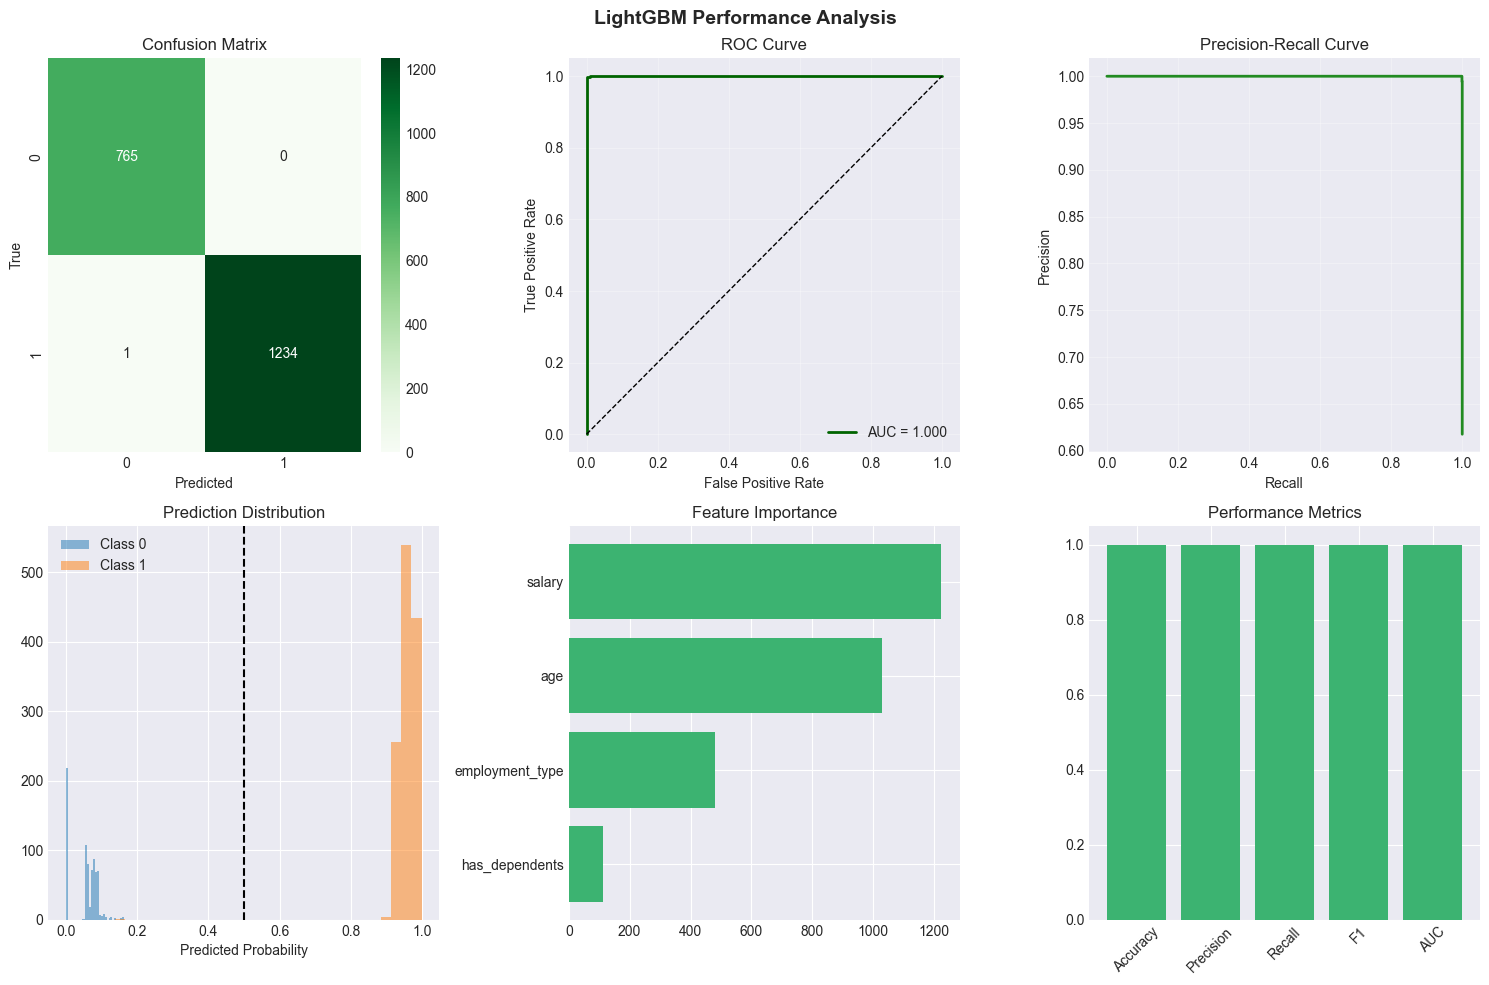

In [14]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('LightGBM Performance Analysis', fontsize=14, fontweight='bold')

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_ylabel('True')
axes[0,0].set_xlabel('Predicted')

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
axes[0,1].plot(fpr, tpr, lw=2, color='darkgreen', 
               label=f'AUC = {roc_auc_score(y_test, y_test_prob):.3f}')
axes[0,1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0,1].set_title('ROC Curve')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_test_prob)
axes[0,2].plot(rec, prec, lw=2, color='forestgreen')
axes[0,2].set_title('Precision-Recall Curve')
axes[0,2].set_xlabel('Recall')
axes[0,2].set_ylabel('Precision')
axes[0,2].grid(alpha=0.3)

# Prediction distribution
axes[1,0].hist(y_test_prob[y_test==0], bins=30, alpha=0.5, label='Class 0')
axes[1,0].hist(y_test_prob[y_test==1], bins=30, alpha=0.5, label='Class 1')
axes[1,0].axvline(0.5, color='k', linestyle='--')
axes[1,0].set_title('Prediction Distribution')
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].legend()

# Feature importance
axes[1,1].barh(range(len(importances)), importances['importance'], color='mediumseagreen')
axes[1,1].set_yticks(range(len(importances)))
axes[1,1].set_yticklabels(importances['feature'])
axes[1,1].set_title('Feature Importance')
axes[1,1].invert_yaxis()

# Metrics comparison
metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1': f1_score(y_test, y_test_pred),
    'AUC': roc_auc_score(y_test, y_test_prob)
}
axes[1,2].bar(range(len(metrics)), list(metrics.values()), color='mediumseagreen')
axes[1,2].set_xticks(range(len(metrics)))
axes[1,2].set_xticklabels(metrics.keys(), rotation=45)
axes[1,2].set_title('Performance Metrics')
axes[1,2].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('lightgbm_results.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
a